In [1]:
import zipfile
from io import BytesIO
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import shutil
from tqdm import tqdm  # For progress bars

In [2]:
# Function to process and store data for each video
def load_videos_from_directory():
    videos = {}

    # Loop through each zip file in the current directory
    for zip_filename in os.listdir():
        if zip_filename.endswith('.zip'):
            print("Processing ", zip_filename)
            with zipfile.ZipFile(zip_filename, 'r') as inner_zip:
                # Create a dictionary for this specific video
                video_data = {}

                # Load the action_continuous.txt if it exists
                if 'action_continuous.txt' in inner_zip.namelist():
                    with inner_zip.open('action_continuous.txt') as action_file:
                        video_data['action_continuous'] = action_file.read().decode('utf-8')

                # Load the action_discrete.txt if it exists
                if 'action_discrete.txt' in inner_zip.namelist():
                    with inner_zip.open('action_discrete.txt') as action_file:
                        video_data['action_discrete'] = action_file.read().decode('utf-8')

                # Load the video_left.avi file if it exists
                if 'video_left.avi' in inner_zip.namelist():
                    with inner_zip.open('video_left.avi') as video_file:
                        video_data['video_left'] = video_file.read()  # You can process the video later

                # Load the segmentation PNG files if they exist
                segmentation_files = {}
                for file_name in inner_zip.namelist():
                    if file_name.startswith('segmentation/') and file_name.endswith('.png'):
                        with inner_zip.open(file_name) as img_file:
                            # Store each PNG file in memory as a binary blob
                            segmentation_files[file_name] = img_file.read()

                # Store the segmentation images in the video dictionary
                video_data['segmentation'] = segmentation_files

                # Extract the video name from the zip filename (e.g., video_1.zip becomes 'video_1')
                video_name = zip_filename.replace('.zip', '')
                videos[video_name] = video_data

    return videos

In [3]:
videos = load_videos_from_directory()

Processing  video_01.zip
Processing  video_02.zip
Processing  video_03.zip
Processing  video_04.zip
Processing  video_05.zip
Processing  video_06.zip
Processing  video_07.zip
Processing  video_08.zip
Processing  video_09.zip
Processing  video_10.zip
Processing  video_11_1.zip
Processing  video_11_2.zip
Processing  video_12.zip
Processing  video_13.zip
Processing  video_14.zip
Processing  video_15_1.zip
Processing  video_15_2.zip
Processing  video_16.zip
Processing  video_17_1.zip
Processing  video_17_2.zip
Processing  video_18.zip
Processing  video_19.zip
Processing  video_20.zip
Processing  video_21.zip
Processing  video_22.zip
Processing  video_23.zip
Processing  video_24.zip
Processing  video_25.zip
Processing  video_26.zip
Processing  video_27.zip
Processing  video_28.zip
Processing  video_29_1.zip
Processing  video_29_2.zip
Processing  video_30.zip
Processing  video_31.zip
Processing  video_32.zip
Processing  video_33.zip
Processing  video_34.zip
Processing  video_35.zip
Processin

# Exploratory Data Analysis of a Single Video Directory

In [4]:
video_1_data = videos['video_01']

In [5]:
type(video_1_data['segmentation']['segmentation/000000000.png'])

bytes

In [6]:
image_bytes = video_1_data['segmentation']['segmentation/000000000.png']

In [7]:
image = Image.open(BytesIO(image_bytes))

In [8]:
arr = np.array(image)
print("Unique pixel values in mask:", np.unique(arr))

Unique pixel values in mask: [0 1 2 3 5]


In [9]:
arr.shape

(1080, 1920, 3)

In [10]:
# Checking if the 3 columns corresponding to the RGB pixels are equal, representing the same classes.
print(np.all(arr[..., 0] == arr[..., 1]))  # Should be True
print(np.all(arr[..., 0] == arr[..., 2]))  # Should be True

True
True


# Generating Training Data From a Single Video Directory

In [11]:
def generate_frame_mask_pairs(videos: dict, video_name: str) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Generates frame-mask pairs from video and segmentation data.
    
    Args:
        videos: Dictionary containing video and segmentation data
        video_name: Key to access specific video data in videos dict
        
    Returns:
        List of tuples containing (frame, mask) pairs
    """
    try:
        video_data = videos[video_name]
        video_bytes = video_data['video_left']
        segmentation_files = video_data['segmentation']

        # Create temporary file for video (OpenCV needs a file path)
        temp_filename = "temp_video.avi"
        with open(temp_filename, 'wb') as f:
            f.write(video_bytes)

        cap = cv2.VideoCapture(temp_filename)
        if not cap.isOpened():
            raise RuntimeError("Failed to open video.")

        paired_data = []
        seg_filenames = sorted(segmentation_files.keys())

        for seg_file in seg_filenames:
            try:
                # Parse frame index from filename
                frame_index = int(os.path.splitext(os.path.basename(seg_file))[0])
                
                # Set video to correct frame
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                ret, frame = cap.read()

                if not ret:
                    print(f"Warning: Failed to read frame at index {frame_index}")
                    continue

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Load segmentation mask
                with Image.open(BytesIO(segmentation_files[seg_file])) as mask_image:
                    mask = np.array(mask_image)
                    # Handle both grayscale and RGB masks
                    if mask.ndim == 3:
                        mask = mask[..., 0]  # take first channel for RGB
                    mask = mask.astype(np.uint8)

                paired_data.append((frame, mask))
                
            except Exception as seg_error:
                print(f"Error processing segmentation {seg_file}: {str(seg_error)}")
                continue

        return paired_data

    finally:
        # Ensure resources are cleaned up
        if 'cap' in locals():
            cap.release()
        if 'temp_filename' in locals() and os.path.exists(temp_filename):
            os.remove(temp_filename)
        print(f"Processed {video_name}")

In [12]:
train_data = generate_frame_mask_pairs(videos, "video_01")
print(len(train_data))  # Number of frame-mask pairs

Processed video_01
563


In [13]:
type(train_data)

list

In [14]:
train_data[0][1].shape

(1080, 1920)

In [15]:
train_data[0][0].shape

(1080, 1920, 3)

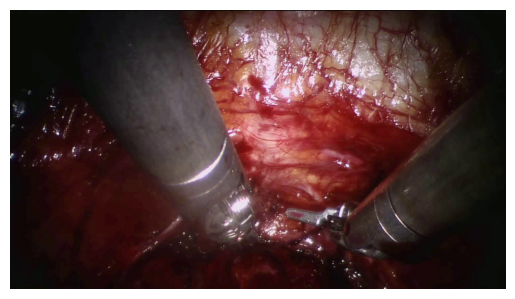

In [16]:
plt.imshow(train_data[0][0])
plt.axis('off')
plt.show()

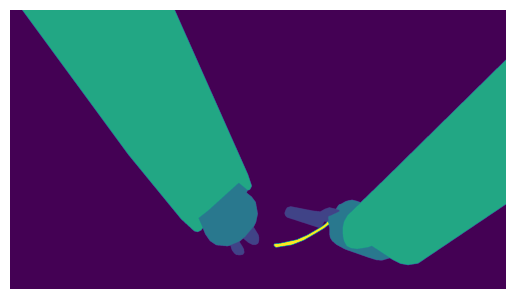

In [17]:
plt.imshow(train_data[0][1])
plt.axis('off')
plt.show()

# Generating Training and Validation Datasets

In [18]:
def generate_datasets(videos: dict, output_dir: str = "dataset"):
    # Create output directories
    train_dir = Path(output_dir) / "train"
    val_dir = Path(output_dir) / "val"
    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)

    # Split dataset keys
    train_data_keys = [key for key in videos.keys() 
                      if not (key.startswith("video_") and 32 <= int(key.split("_")[1]) <= 40)]
    val_data_keys = [key for key in videos.keys() 
                     if key.startswith("video_") and 32 <= int(key.split("_")[1]) <= 40]

    def process_videos(keys, output_path, desc):
        """Process videos sequentially with progress tracking"""
        paths = []
        for key in tqdm(keys, desc=desc):
            try:
                pairs = generate_frame_mask_pairs(videos, key)
                for i, (frame, mask) in enumerate(pairs):
                    frame_path = output_path / f"{key}_frame_{i}.npy"
                    mask_path = output_path / f"{key}_mask_{i}.npy"
                    
                    np.save(frame_path, frame)
                    np.save(mask_path, mask)
                    paths.append((frame_path, mask_path))
            except Exception as e:
                print(f"Error processing {key}: {str(e)}")
        return paths

    print("Processing training set...")
    train_paths = process_videos(train_data_keys, train_dir, "Training Videos")
    
    print("Processing validation set...")
    val_paths = process_videos(val_data_keys, val_dir, "Validation Videos")

    print(f"Completed. Saved {len(train_paths)} training pairs and {len(val_paths)} validation pairs.")
    return train_paths, val_paths

In [19]:
train_data, val_data = generate_datasets(videos, output_dir="data")

Processing training set...


Training Videos:   0%|                                                                          | 0/35 [00:00<?, ?it/s]

Processed video_01


Training Videos:   3%|█▊                                                             | 1/35 [01:48<1:01:17, 108.17s/it]

Processed video_02


Training Videos:   6%|███▊                                                              | 2/35 [02:49<44:25, 80.77s/it]

Processed video_03


Training Videos:   9%|█████▋                                                            | 3/35 [04:18<44:57, 84.31s/it]

Processed video_04


Training Videos:  11%|███████▌                                                          | 4/35 [04:38<30:31, 59.07s/it]

Processed video_05


Training Videos:  14%|█████████▍                                                        | 5/35 [05:29<28:04, 56.14s/it]

Processed video_06


Training Videos:  17%|███████████▎                                                      | 6/35 [08:08<44:01, 91.08s/it]

Processed video_07


Training Videos:  20%|█████████████▏                                                    | 7/35 [09:00<36:34, 78.37s/it]

Processed video_08


Training Videos:  23%|███████████████                                                   | 8/35 [09:20<26:48, 59.56s/it]

Processed video_09


Training Videos:  26%|████████████████▉                                                 | 9/35 [10:02<23:30, 54.24s/it]

Processed video_10


Training Videos:  29%|██████████████████▌                                              | 10/35 [10:28<18:55, 45.41s/it]

Processed video_11_1


Training Videos:  31%|████████████████████▍                                            | 11/35 [11:11<17:53, 44.74s/it]

Processed video_11_2


Training Videos:  34%|██████████████████████▎                                          | 12/35 [11:37<14:56, 38.99s/it]

Processed video_12


Training Videos:  37%|████████████████████████▏                                        | 13/35 [12:05<13:07, 35.80s/it]

Processed video_13


Training Videos:  40%|██████████████████████████                                       | 14/35 [13:03<14:49, 42.35s/it]

Processed video_14


Training Videos:  43%|███████████████████████████▊                                     | 15/35 [13:55<15:05, 45.27s/it]

Processed video_15_1


Training Videos:  46%|█████████████████████████████▋                                   | 16/35 [14:25<12:55, 40.79s/it]

Processed video_15_2


Training Videos:  49%|███████████████████████████████▌                                 | 17/35 [14:51<10:53, 36.33s/it]

Processed video_16


Training Videos:  51%|█████████████████████████████████▍                               | 18/35 [16:00<13:06, 46.25s/it]

Processed video_17_1


Training Videos:  54%|███████████████████████████████████▎                             | 19/35 [16:51<12:39, 47.49s/it]

Processed video_17_2


Training Videos:  57%|█████████████████████████████████████▏                           | 20/35 [17:11<09:51, 39.42s/it]

Processed video_18


Training Videos:  60%|███████████████████████████████████████                          | 21/35 [18:45<12:58, 55.62s/it]

Processed video_19


Training Videos:  63%|████████████████████████████████████████▊                        | 22/35 [19:34<11:37, 53.66s/it]

Processed video_20


Training Videos:  66%|██████████████████████████████████████████▋                      | 23/35 [20:23<10:26, 52.22s/it]

Processed video_21


Training Videos:  69%|████████████████████████████████████████████▌                    | 24/35 [21:48<11:22, 62.08s/it]

Processed video_22


Training Videos:  71%|██████████████████████████████████████████████▍                  | 25/35 [22:53<10:30, 63.06s/it]

Processed video_23


Training Videos:  74%|████████████████████████████████████████████████▎                | 26/35 [23:39<08:39, 57.75s/it]

Processed video_24


Training Videos:  77%|██████████████████████████████████████████████████▏              | 27/35 [24:31<07:29, 56.17s/it]

Processed video_25


Training Videos:  80%|████████████████████████████████████████████████████             | 28/35 [24:59<05:33, 47.68s/it]

Processed video_26


Training Videos:  83%|█████████████████████████████████████████████████████▊           | 29/35 [25:28<04:12, 42.07s/it]

Processed video_27


Training Videos:  86%|███████████████████████████████████████████████████████▋         | 30/35 [26:00<03:14, 38.98s/it]

Processed video_28


Training Videos:  89%|█████████████████████████████████████████████████████████▌       | 31/35 [26:37<02:33, 38.39s/it]

Processed video_29_1


Training Videos:  91%|███████████████████████████████████████████████████████████▍     | 32/35 [27:18<01:57, 39.32s/it]

Processed video_29_2


Training Videos:  94%|█████████████████████████████████████████████████████████████▎   | 33/35 [28:01<01:20, 40.33s/it]

Processed video_30


Training Videos:  97%|███████████████████████████████████████████████████████████████▏ | 34/35 [29:39<00:57, 57.54s/it]

Processed video_31


Training Videos: 100%|█████████████████████████████████████████████████████████████████| 35/35 [31:29<00:00, 53.99s/it]


Processing validation set...


Validation Videos:   0%|                                                                         | 0/9 [00:00<?, ?it/s]

Processed video_32


Validation Videos:  11%|███████▏                                                         | 1/9 [01:17<10:16, 77.06s/it]

Processed video_33


Validation Videos:  22%|██████████████▍                                                  | 2/9 [01:45<05:38, 48.38s/it]

Processed video_34


Validation Videos:  33%|█████████████████████▋                                           | 3/9 [02:02<03:25, 34.21s/it]

Processed video_35


Validation Videos:  44%|████████████████████████████▉                                    | 4/9 [03:41<04:59, 59.86s/it]

Processed video_36


Validation Videos:  56%|████████████████████████████████████                             | 5/9 [04:50<04:12, 63.03s/it]

Processed video_37


Validation Videos:  67%|███████████████████████████████████████████▎                     | 6/9 [05:51<03:06, 62.24s/it]

Processed video_38


Validation Videos:  78%|██████████████████████████████████████████████████▌              | 7/9 [06:48<02:01, 60.63s/it]

Processed video_39


Validation Videos:  89%|█████████████████████████████████████████████████████████▊       | 8/9 [07:31<00:54, 54.96s/it]

Processed video_40


Validation Videos: 100%|█████████████████████████████████████████████████████████████████| 9/9 [08:28<00:00, 56.54s/it]


Completed. Saved 10270 training pairs and 2773 validation pairs.


In [19]:
def generate_test_dataset(videos: dict, output_dir: str = "dataset"):
    # Create output directories
    test_dir = Path(output_dir) / "test"
    test_dir.mkdir(parents=True, exist_ok=True)

    # Generate dataset keys
    test_data_keys = [key for key in videos.keys() 
                     if key.startswith("video_") and 41 <= int(key.split("_")[1])]

    def process_videos(keys, output_path, desc):
        """Process videos sequentially with progress tracking"""
        paths = []
        for key in tqdm(keys, desc=desc):
            try:
                pairs = generate_frame_mask_pairs(videos, key)
                for i, (frame, mask) in enumerate(pairs):
                    frame_path = output_path / f"{key}_frame_{i}.npy"
                    mask_path = output_path / f"{key}_mask_{i}.npy"
                    
                    np.save(frame_path, frame)
                    np.save(mask_path, mask)
                    paths.append((frame_path, mask_path))
            except Exception as e:
                print(f"Error processing {key}: {str(e)}")
        return paths

    print("Processing testing set...")
    test_paths = process_videos(test_data_keys, test_dir, "Testing Videos")

    print(f"Completed. Saved {len(test_paths)} testing pairs.")
    return test_paths

In [20]:
test_data = generate_test_dataset(videos, output_dir="data")

Processing testing set...


Testing Videos:   0%|                                                                           | 0/10 [00:00<?, ?it/s]

Processed video_41


Testing Videos:  10%|██████▋                                                            | 1/10 [00:37<05:37, 37.52s/it]

Processed video_42


Testing Videos:  20%|█████████████▍                                                     | 2/10 [01:51<07:50, 58.84s/it]

Processed video_43


Testing Videos:  30%|████████████████████                                               | 3/10 [02:32<05:56, 50.86s/it]

Processed video_44


Testing Videos:  40%|██████████████████████████▊                                        | 4/10 [02:53<03:52, 38.82s/it]

Processed video_45


Testing Videos:  50%|█████████████████████████████████▌                                 | 5/10 [03:14<02:42, 32.54s/it]

Processed video_46


Testing Videos:  60%|████████████████████████████████████████▏                          | 6/10 [04:54<03:41, 55.48s/it]

Processed video_47


Testing Videos:  70%|██████████████████████████████████████████████▉                    | 7/10 [05:58<02:54, 58.24s/it]

Processed video_48


Testing Videos:  80%|█████████████████████████████████████████████████████▌             | 8/10 [06:38<01:45, 52.58s/it]

Processed video_49


Testing Videos:  90%|████████████████████████████████████████████████████████████▎      | 9/10 [08:40<01:14, 74.24s/it]

Processed video_50


Testing Videos: 100%|██████████████████████████████████████████████████████████████████| 10/10 [09:29<00:00, 56.99s/it]


Completed. Saved 3252 testing pairs.
